**넷플릭스 데이터를 활용한 추천 시스템 개발**
- netflix_titles.csv 데이터를 활용하여 주요 데이터 시각화 및 추천 시스템을 개발하시오
- 각 마크다운 셀의 내용을 참고하여 코드를 작성한다.
- <font color='red'><b>빨간색</b></font>으로 표기된 영역은 이미 작성되어 있는 코드로 그대로 활용하면 된다.

# 데이터 로딩

In [1]:
import pandas as pd

netflix = pd.read_csv('netflix_titles.csv')
print(netflix.shape)
netflix.head(5)

(7787, 12)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


# 주요 데이터 시각화

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

## TV Show vs Movies (콘텐츠 타입) 막대 그래프

In [3]:
netflix['type'].value_counts()

Movie      5377
TV Show    2410
Name: type, dtype: int64

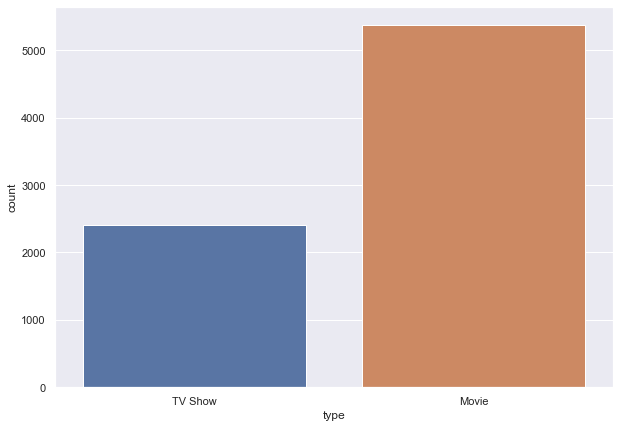

In [4]:
plt.figure(figsize=(10,7))
sns.set(style="darkgrid")
ax = sns.countplot(x="type", data=netflix)
plt.show()

## 제작 국가별 수평 막대 그래프
- 결측 값 확인 및 결측 값 레코드 삭제
- 2개 이상의 제작국가 값을 가지고 있는 레코드는 ‘,’를 기준으로 분류하여 카운팅 한다.
- 상위 10개국에 대한 막대그래프를 그린다.

In [5]:
netflix['country'].isna().sum()

507

In [2]:
n = netflix.dropna(subset=['country'])
n.shape

(7280, 12)

In [3]:
import numpy as np

country_count_dic = {}
for record in n['country']:
    for country in record.split(','):
        country_count_dic[country.strip()] = country_count_dic.get(country.strip(), 0) + 1

data = {'Country':list(country_count_dic.keys()),
        'Count':list(country_count_dic.values())}
country_df = pd.DataFrame(data)
country_df_10 = country_df.sort_values('Count', ascending=False).head(10)

# country_df_10 = country_df[country_df.columns[:10]]
country_df_10.index = np.arange(country_df_10.shape[0])

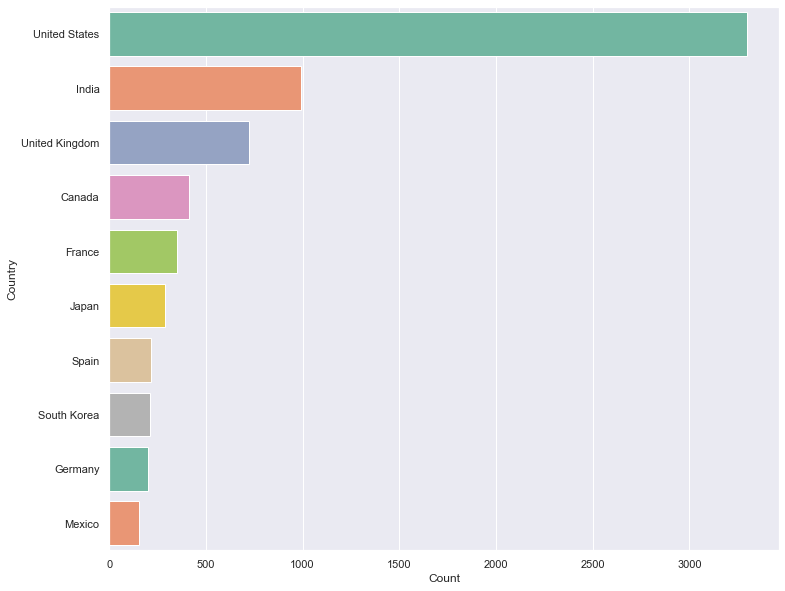

In [6]:
plt.figure(figsize=(12,10))
sns.set(style="darkgrid")
ax = sns.barplot(y="Country", x='Count', data=country_df_10, palette="Set2", orient='h')
plt.show()

# 제목, 장르, 요약내용 특성 값을 기반으로 한 콘텐츠 기반 필터링 추천

## 데이터 전처리

### 추천 알고리즘 분석과 관련한 컬럼만 추출
- 추출 대상 컬럼: 'show_id', 'title', 'listed_in', 'description'    

In [2]:
netflix_df = netflix[['show_id', 'title', 'listed_in', 'description']]
netflix_df.head()

,show_id,title,listed_in,description
0,s1,3%,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,7:19,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,23:59,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,9,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,21,Dramas,A brilliant group of students become card-coun...


### <font color='red'> 형태소 분석 - 1 </font>
- title, listed_in, description 컬럼에 있는 텍스트 데이터의 모든 단어를 소문자로 변경
- nltk (Natural Language Tookit)을 활용하여 단어를 토큰
- <font color='red'><b>[주의]</b></font>: 위 코드에서 분석에 필요한 컬럼만 추출해서 만든 DataFrame 객체의 변수 이름을 **netflix_df**로 한다.

In [3]:
# 파이썬 경고 메세지 출력 안하
import warnings
warnings.filterwarnings(action='ignore')

In [4]:
import nltk
nltk.download('stopwords') # 구두점 사전 다운로드
nltk.download('punkt') # 불용어 사전 다운로드

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\spiri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\spiri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
from nltk.tokenize import word_tokenize

netflix_df['title_list'] = netflix_df['title'].str.lower()
netflix_df['listed_in'] = netflix_df['listed_in'].str.lower()
netflix_df['description'] = netflix_df['description'].str.lower()

netflix_df['title_list'] = netflix_df['title_list'].apply(word_tokenize)
netflix_df['listed_in'] = netflix_df['listed_in'].apply(word_tokenize)
netflix_df['description'] = netflix_df['description'].apply(word_tokenize)

In [11]:
netflix_df.head()

,show_id,title,listed_in,description,title_list
0,s1,3%,"[international, tv, shows, ,, tv, dramas, ,, t...","[in, a, future, where, the, elite, inhabit, an...","[3, %]"
1,s2,7:19,"[dramas, ,, international, movies]","[after, a, devastating, earthquake, hits, mexi...",[7:19]
2,s3,23:59,"[horror, movies, ,, international, movies]","[when, an, army, recruit, is, found, dead, ,, ...",[23:59]
3,s4,9,"[action, &, adventure, ,, independent, movies,...","[in, a, postapocalyptic, world, ,, rag-doll, r...",[9]
4,s5,21,[dramas],"[a, brilliant, group, of, students, become, ca...",[21]


### <font color='red'> 형태소 분석 - 2 </font> (토큰 된 각 단어가 불용어인 경우 제거)
- 단어별로 토큰 된 title_list, listed_in, description 컬럼 데이터 중 nltk 라이브러리의 stopwords 패키지를 활용하여 불용어를 제거한다.

In [6]:
from nltk.corpus import stopwords
from string import punctuation

list_stopwords = set(stopwords.words('english') + list(punctuation))
netflix_df['title_list'] = netflix_df['title_list'].apply(lambda x: [word for word in x if word not in list_stopwords])
netflix_df['listed_in'] = netflix_df['listed_in'].apply(lambda x: [word for word in x if word not in list_stopwords])
netflix_df['description'] = netflix_df['description'].apply(lambda x: [word for word in x if word not in list_stopwords])

In [13]:
netflix_df.head()

,show_id,title,listed_in,description,title_list
0,s1,3%,"[international, tv, shows, tv, dramas, tv, sci...","[future, elite, inhabit, island, paradise, far...",[3]
1,s2,7:19,"[dramas, international, movies]","[devastating, earthquake, hits, mexico, city, ...",[7:19]
2,s3,23:59,"[horror, movies, international, movies]","[army, recruit, found, dead, fellow, soldiers,...",[23:59]
3,s4,9,"[action, adventure, independent, movies, sci-f...","[postapocalyptic, world, rag-doll, robots, hid...",[9]
4,s5,21,[dramas],"[brilliant, group, students, become, card-coun...",[21]


### <font color='red'> 형태소 분석 - 3 </font> (단어 안에 포함된 불용어 제거)
- title_list, listed_in, description 컬럼 데이터에 포함된 구두점을 제거한다.

In [7]:
import string

string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

- translate()와maketrans()는 정규식 이외의 다른 접근 방식을 사용하며 사전을 사용하여 이전 값을 새 값으로 매핑
- maketrans()는  원래 문자열과 대체 문자열 간의 매핑 테이블 역할을 한다.
    - str1 - 대체 할 문자열
    - str2 - str1 문자를 대체하는 문자열
    - str3 - 삭제할 문자열
- translate()는 maketrans()가 반환하는 모든 것을 받아 번역 된 문자열을 생성한다.

In [8]:
netflix_df['title_list'] = netflix_df['title_list'].apply(lambda x : [word.translate(str.maketrans('', '', string.punctuation)) for word in x])
netflix_df['listed_in'] = netflix_df['listed_in'].apply(lambda x : [word.translate(str.maketrans('', '', string.punctuation)) for word in x])
netflix_df['description'] = netflix_df['description'].apply(lambda x : [word.translate(str.maketrans('', '', string.punctuation)) for word in x])

### 형태소 분석 - 4
- title_list, listed_in, description 컬럼 데이터에 포함된 중복 단어를 제거한다. **(set() 함수 이용)**

In [9]:
netflix_df['title_list'] = netflix_df['title_list'].apply(lambda x : list(set(x)))
netflix_df['listed_in'] = netflix_df['listed_in'].apply(lambda x : list(set(x)))
netflix_df['description'] = netflix_df['description'].apply(lambda x : list(set(x)))

# 콘텐츠 유사도 측정

## 피처 벡터화
- title_list, listed_in, description 컬럼의 각 단어를 공백문자로 구분되는 문자열로 변환하여 카운트 기반으로 피처 벡터화 한다.**(CountVectorizer 이용)**
- title_list, listed_in, description 각 컬럼의 피처 벡터화한 결과를 **matrix_netflix_vocab = []** 리스트에 저장한다.

In [54]:
netflix_df['title_literal'] = netflix_df['title_list'].apply(lambda x : (' ').join(x))
netflix_df['listed_in_literal'] = netflix_df['listed_in'].apply(lambda x : (' ').join(x))
netflix_df['description_literal'] = netflix_df['description'].apply(lambda x : (' ').join(x))

In [55]:
from sklearn.feature_extraction.text import CountVectorizer

matrix_netflix_vocab = []
count_vect = CountVectorizer(min_df=0, ngram_range=(1,1))
col_list = ['title_literal', 'listed_in_literal', 'description_literal']
for col in col_list:
    matrix = count_vect.fit_transform(netflix_df[col])
    matrix_netflix_vocab.append(matrix)

In [21]:
matrix_netflix_vocab[0].shape

(7787, 8163)

In [22]:
matrix_netflix_vocab[1].shape

(7787, 45)

## 코사인 유사도
- title_list, listed_in, description 각 컬럼에 대해 피처 백터화 한 값을 이용하여 각각의 코사인 유사도를 산출하여 **matrix_netflix_sim = []** 리스트에 저장한다.

In [56]:
from sklearn.metrics.pairwise import cosine_similarity

matrix_netflix_sim = [] 
for mat in matrix_netflix_vocab:
    sim = cosine_similarity(mat, mat)
    matrix_netflix_sim.append(sim)

In [57]:
len(matrix_netflix_sim[0][0,:])

7787

In [25]:
matrix_netflix_sim[2][0,:].min(), matrix_netflix_sim[2][0,:].max()

(0.0, 0.9999999999999999)

- title_list, listed_in, description에 대해 각각 유사도가 높은 순으로 정렬한 콘텐츠의 인덱스를 **netflix_sim_sorted_ind = []** 리스트에 저장한다.

In [58]:
netflix_sim_sorted_ind = []
# netflix_sim_sorted = [] 
for sim in matrix_netflix_sim:
    sim_sorted_ind = sim.argsort()[:, ::-1]
#     sim_sorted = np.sort(sim)[:, ::-1]
    netflix_sim_sorted_ind.append(sim_sorted_ind)
#     netflix_sim_sorted.append(sim_sorted)    

# 유사도 필터링을 이용한 넷플릭스 콘텐츠 추천

- 추천 기준이 되는 콘텐츠의 제목으로 해당 콘텐츠 레코드를 추출한다.
- 추출된 콘텐츠의 인덱스 (netflix_df 데이터 프레임에서의 레코드 위치)를 추출한다.
- 해당 인덱스로 sorted_ind_list 인자로 입력된 genre_sim_sorted_ind 객체에서 각 컬럼별 유사도 순으로 top_n 개의 index를 추출한 후 리스트에 저장한다.
- 함수 매개변수
    - df: 넷플릭스 콘텐츠 정보 DataFrame
    - sorted_ind_list: title_list, listed_in, description에 대해 각각 유사도가 높은 순으로 정렬한 콘텐츠의 인덱스 행렬을 저장한 리스트
    - title_name: 추천 기준이 되는 콘텐츠 제목 (해당 콘텐츠와 장르 유사도가 높은 콘텐츠를 추천)
    - top_n: 추천 콘텐츠 건수

In [59]:
def find_sim_netflix(df, sorted_ind_list, title_name, top_n=10):
    target_contents = df[df['title'] == title_name]
    target_index = target_contents.index.values
    similar_indexes_list = []
    for sorted_ind in sorted_ind_list:
        similar_indexes = sorted_ind[target_index, :(top_n)]
        similar_indexes_list.append(similar_indexes)
    
    return df.iloc[np.array(similar_indexes_list).flatten()]

In [60]:
# '응답하라 1988' 과 제목, 장르, 줄거리가 유사한 콘텐츠를 각각 10개씩 추천
similar_netflix = find_sim_netflix(netflix_df, netflix_sim_sorted_ind, 'Reply 1988',10)

In [65]:
similar_netflix[['title']].drop_duplicates() #.sort_values('title')

,title
5161,Reply 1988
5162,Reply 1994
5163,Reply 1997
2599,Hannah Gadsby: Nanette
2598,Hannah Gadsby: Douglas
2597,Hank: Five Years from the Brink
2596,Hangman
2595,Hangar 1: The UFO Files
2594,Handsome: A Netflix Mystery Movie
7786,ZZ TOP: THAT LITTLE OL' BAND FROM TEXAS
